In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, 

####Read in sample metadata

In [5]:
%%R
sample.md = read.table("data/Chazy_BulkSIP_mapping.txt", 
                comment.char = "",
                header = TRUE)
                #colClasses = c("Density" = "numeric"))
rownames(sample.md) = as.character(sample.md[, 1])

sample.md = sample_data(sample.md)

####Read in OTU table

In [6]:
%%R
physeq = import_biom("data/otu_table_250_wtax.biom") 

####Add sample metadata to phyloseq object

In [7]:
%%R
sample_data(physeq) = sample.md
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3676 taxa and 112 samples ]
sample_data() Sample Data:       [ 112 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 3676 taxa by 8 taxonomic ranks ]


####Function for estimating fold change and standard error with DESeq2

In [9]:
%%R
get_l2fc = function(physeq.obj, Day, Substrate) {
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Day == Day) & (physeq.md$Substrate == Substrate), physeq.obj)
    dds = phyloseq_to_deseq2(p, ~ Till)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

####Function arguments

In [10]:
%%R
m = expand.grid(Day = c(1,3,7,14,30), Substrate = c("12C", "13C", "13X", "H2O"))
m = m[-c(6, 15, 16:19), ]
m

   Day Substrate
1    1       12C
2    3       12C
3    7       12C
4   14       12C
5   30       12C
7    3       13C
8    7       13C
9   14       13C
10  30       13C
11   1       13X
12   3       13X
13   7       13X
14  14       13X
20  30       H2O


####mdply call with function arguments

In [11]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(m, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq))
df.l2fc

Source: local data frame [51,464 x 14]

   Day Substrate      OTU log2FoldChange     lfcSE      padj    Rank1
1    1       12C  OTU.201     -0.4211003 0.5544208 0.6679282 Bacteria
2    1       12C   OTU.12      3.7511396 1.2417395 0.4277573 Bacteria
3    1       12C  OTU.675      1.9201287 1.2258982 0.6112257 Bacteria
4    1       12C   OTU.88      1.7037071 1.1196827 0.6112257 Bacteria
5    1       12C OTU.1582     -0.1079672 0.8130581 0.9516325 Bacteria
6    1       12C  OTU.114      0.8800625 0.8787078 0.6163152 Bacteria
7    1       12C OTU.1106      0.4127131 0.7905260 0.8012591 Bacteria
8    1       12C OTU.1496      1.1264014 1.6606577 0.7105013 Bacteria
9    1       12C  OTU.334      0.3630300 0.6584024 0.7799788 Bacteria
10   1       12C OTU.1877      0.1145096 0.9470543 0.9543719 Bacteria
.. ...       ...      ...            ...       ...       ...      ...
Variables not shown: Rank2 (fctr), Rank3 (fctr), Rank4 (fctr), Rank5 (fctr),
  Rank6 (fctr), Rank7 (fctr), Rank8 (fctr)


#### Finding l2fc threshold as defined by 1 sd away from the mean l2fc for RNA/DNA combined

In [12]:
%%R
summarise(ungroup(df.l2fc),
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

   meanl2fc
1 -0.157697


In [13]:
%%R
summarise(ungroup(df.l2fc),
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
1 1.924884


#### log2fold change threshold set at 2.3

####Now get sparsity info for each OTU

In [15]:
%%R
mdf.heavy = tbl_df(psmelt(physeq))

In [21]:
%%R
sparsity.df = mdf.heavy %>%
    group_by(OTU, Day, Substrate) %>%
    summarize(sparsity = sum(Abundance > 0) / length(Abundance)) %>%
    #filter(Treatment == "13CCPS") %>%
    select(OTU, Day, Substrate, sparsity)

sparsity.df

Source: local data frame [58,816 x 4]
Groups: OTU, Day

     OTU Day Substrate sparsity
1  OTU.1   1       12C        1
2  OTU.1   1       13C        1
3  OTU.1   1       13X        1
4  OTU.1   3       12C        1
5  OTU.1   3       13C        1
6  OTU.1   3       13X        1
7  OTU.1   7       12C        1
8  OTU.1   7       13C        1
9  OTU.1   7       13X        1
10 OTU.1  14       12C        1
..   ... ...       ...      ...


####Add sparsity information to l2fc table

In [22]:
%%R
df.l2fc = left_join(df.l2fc, sparsity.df)

Joining by: c("Day", "Substrate", "OTU")


####Add p-values to l2fc table

In [36]:
%%R
l2fc.threshold = 0
df.l2fc$p = with(df.l2fc, pnorm(log2FoldChange, l2fc.threshold, lfcSE))

In [37]:
%%R
filter(df.l2fc, log2FoldChange < -4)

Source: local data frame [130 x 16]

   Day Substrate      OTU log2FoldChange    lfcSE      padj    Rank1
1    1       12C  OTU.503      -4.494322 2.280922 0.6415674 Bacteria
2    1       12C OTU.2049      -4.457263 2.325905 0.6636963 Bacteria
3    1       12C  OTU.274      -6.112297 2.114603 0.2431254 Bacteria
4    1       12C OTU.2534      -4.341931 2.284930 0.6702933 Bacteria
5    1       12C  OTU.636      -4.733523 2.292380 0.5935497 Bacteria
6    1       12C OTU.1747      -4.184726 2.316403 0.6977965 Bacteria
7    1       12C  OTU.422      -6.063722 2.203683 0.2920978 Bacteria
8    1       12C  OTU.406      -4.355791 2.334673 0.6764240 Bacteria
9    1       12C OTU.2860      -4.117353 2.325537 0.7130187 Bacteria
10   1       12C OTU.2424      -4.650067 2.255163 0.5957949 Bacteria
.. ...       ...      ...            ...      ...       ...      ...
Variables not shown: Rank2 (fctr), Rank3 (fctr), Rank4 (fctr), Rank5 (fctr),
  Rank6 (fctr), Rank7 (fctr), Rank8 (fctr), p (dbl), spars

####Plot sparsity threshold versus number of adjusted p-values less than FDR

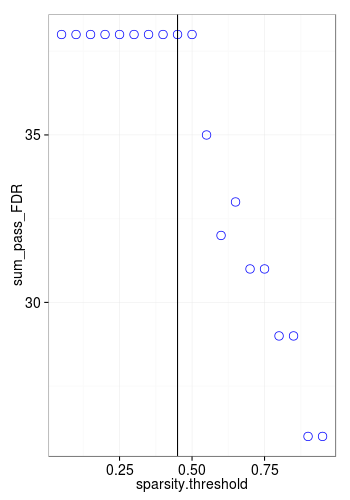

In [38]:
%%R -w 350 -h 500
FDR = 0.10

count_sig = function(df, sparsity.threshold) {
    d = df %>%
            filter(sparsity >= sparsity.threshold) %>%
            mutate(padj = p.adjust(p, method = "BH"))%>% 
            summarize(sum_pass_FDR = sum(padj <= FDR))
    d
}

thresh = seq(0.05, 0.95, 0.05)
names(thresh) = thresh

d.sparsity = ldply(thresh, count_sig, .id = "sparsity.threshold", df = df.l2fc)
d.sparsity$sparsity.threshold = as.numeric(as.character(d.sparsity$sparsity.threshold))

p = ggplot(d.sparsity, aes(x = sparsity.threshold, y = sum_pass_FDR))

#p = p + facet_wrap(~RNA_DNA, ncol = 1, scales = "free_y")

p = p + geom_point(size = 4, shape = 21, color = "blue")

p = p + geom_vline(x = 0.45)

p = p + theme_bw()
    
p = p + theme(axis.text = element_text(size = 14),
              axis.title = element_text(size = 14),
              strip.text = element_text(size = 14),
              strip.background = element_blank())

p

####Remove OTU/Day/RNA_DNA rows below sparsity threshold and add adjusted p-value to l2fc table 

In [39]:
%%R
sparsity.threshold = 0.45
df.l2fc = df.l2fc %>% 
    filter(sparsity >= sparsity.threshold) %>%
    mutate(padj = p.adjust(p, method = "BH"))
df.l2fc

Source: local data frame [15,073 x 16]

   Day Substrate      OTU log2FoldChange     lfcSE     padj    Rank1
1    1       12C  OTU.201     -0.4211003 0.5544208 0.985347 Bacteria
2    1       12C   OTU.12      3.7511396 1.2417395 1.000000 Bacteria
3    1       12C  OTU.675      1.9201287 1.2258982 1.000000 Bacteria
4    1       12C   OTU.88      1.7037071 1.1196827 1.000000 Bacteria
5    1       12C OTU.1582     -0.1079672 0.8130581 1.000000 Bacteria
6    1       12C  OTU.114      0.8800625 0.8787078 1.000000 Bacteria
7    1       12C OTU.1106      0.4127131 0.7905260 1.000000 Bacteria
8    1       12C OTU.1496      1.1264014 1.6606577 1.000000 Bacteria
9    1       12C  OTU.334      0.3630300 0.6584024 1.000000 Bacteria
10   1       12C OTU.1877      0.1145096 0.9470543 1.000000 Bacteria
.. ...       ...      ...            ...       ...      ...      ...
Variables not shown: Rank2 (fctr), Rank3 (fctr), Rank4 (fctr), Rank5 (fctr),
  Rank6 (fctr), Rank7 (fctr), Rank8 (fctr), p (dbl), sp

In [19]:
%%R
write.table(df.l2fc, "data/l2fc.csv", row.names = FALSE, sep = ",")
df.l2fc

Source: local data frame [1,892 x 15]

   Day     OTU log2FoldChange     lfcSE    Rank1           Rank2
1    3  OTU.40     -1.7995959 0.3482440 k__Fungi   p__Ascomycota
2    3   OTU.7      2.7460387 0.4049920 k__Fungi   p__Ascomycota
3    3   OTU.5     -0.3195079 0.5060621 k__Fungi   p__Ascomycota
4    3   OTU.3     -0.3862363 0.3147093 k__Fungi   p__Ascomycota
5    3  OTU.16      0.4177197 0.2757979 k__Fungi   p__Ascomycota
6    3  OTU.11     -1.5514248 0.3555538 k__Fungi   p__Ascomycota
7    3  OTU.33      0.1792172 0.5108838 k__Fungi p__unidentified
8    3   OTU.4      1.4770349 0.5564977 k__Fungi p__unidentified
9    3   OTU.1      2.1137485 0.4453256 k__Fungi              NA
10   3 OTU.466     -2.4615766 0.9747627 k__Fungi   p__Ascomycota
.. ...     ...            ...       ...      ...             ...
Variables not shown: Rank3 (fctr), Rank4 (fctr), Rank5 (fctr), Rank6 (fctr),
  Rank7 (fctr), RNA_DNA (fctr), sparsity (dbl), p (dbl), padj (dbl)


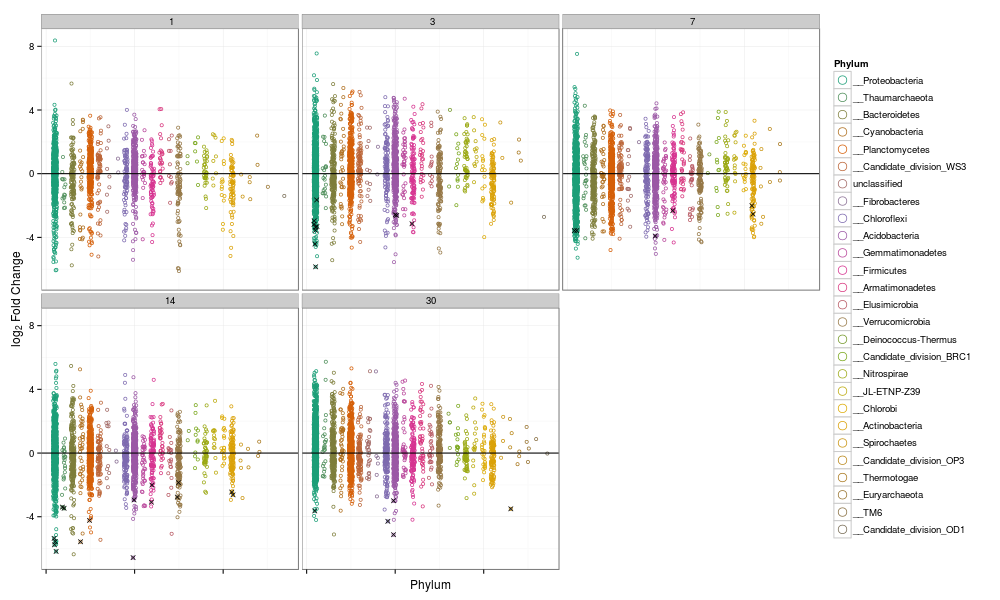

In [40]:
%%R -w 1000 -h 600
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_wrap(~Day)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 2)

p = p + geom_hline(y = l2fc.threshold)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

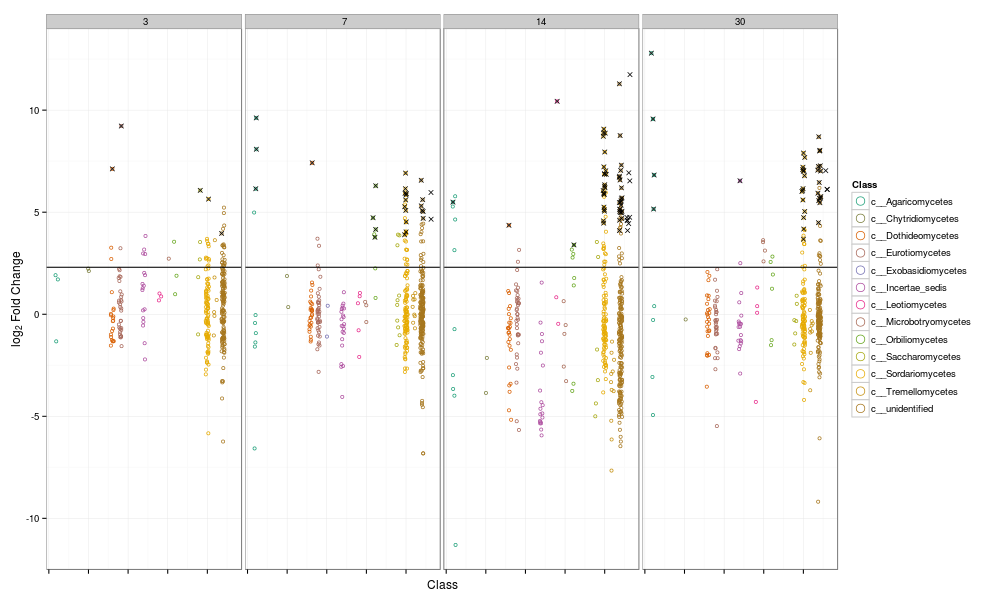

In [37]:
%%R -w 1000 -h 600
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank3)
d$Rank2[is.na(d$Rank3)] = "unclassified"
d$Rank2 = factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank3))
p = p + facet_wrap(~Day, nrow=1, ncol=4)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 2)

p = p + geom_hline(y = l2fc.threshold)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", color = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

In [39]:
%%R

#OTUS that are responders by day
Day3 = filter(df.l2fc, Day == 3, padj <=0.10)
Day7 = filter(df.l2fc, Day == 7, padj <=0.10)
Day14 = filter(df.l2fc, Day == 14, padj <=0.10)
Day30 = filter(df.l2fc, Day == 30, padj <=0.10)

print(length(Day3$OTU))
print(length(Day7$OTU))
print(length(Day14$OTU))
print(length(Day30$OTU))


[1] 5
[1] 27
[1] 58
[1] 38


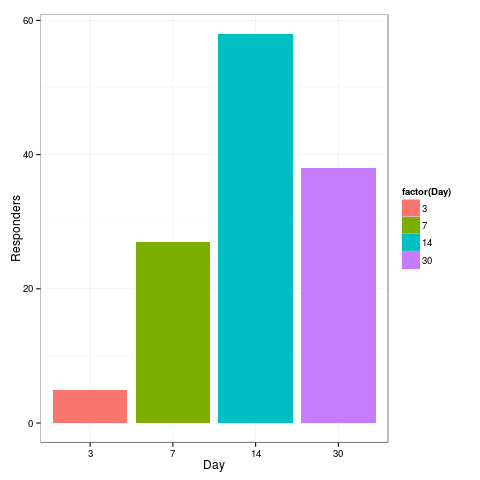

In [40]:
%%R
d = df.l2fc %>%
          group_by(Day) %>%
          summarize(responders = sum(padj <= 0.10))

px = ggplot(d, aes(x = factor(Day), y = responders, fill = factor(Day)))

px = px + geom_bar(stat = "identity", position = "dodge")

px = px + theme_bw()

px = px + xlab("Day") + ylab("Responders")


px

In [77]:
%%R
ggsave(filename = "data/figs/l2fc_histogram", plot = px, width = 12, height = 7)

In [41]:
%%R
 new_df.l2fc = df.l2fc %>% 
filter(!is.na(log2FoldChange)) %>% 
filter(!is.na(padj)) %>%
select(log2FoldChange, padj, OTU, Rank5) 

In [42]:
%%R
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = "non-responder/unknown"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange > 0] = "Responder"

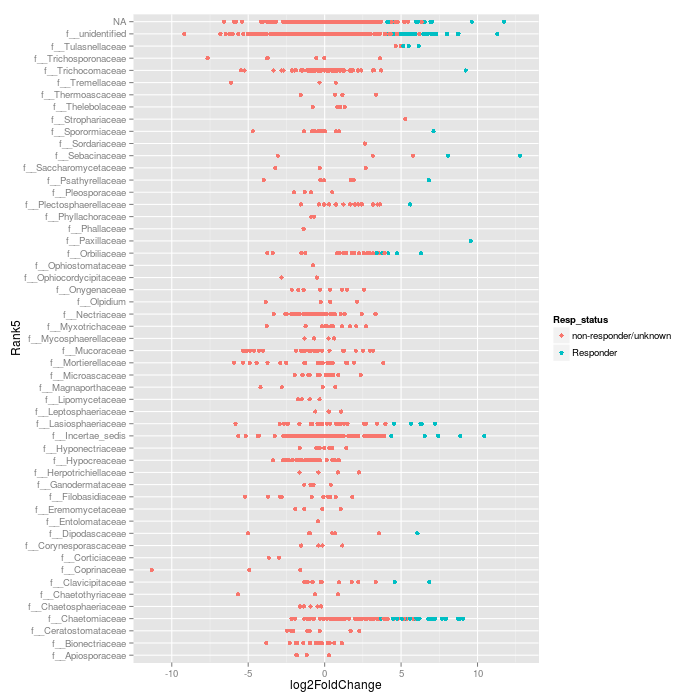

In [46]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank5))
p = p + geom_point(aes(color = Resp_status))
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p

## Blasting against Living Tree Project db

In [ ]:
from Bio.Blast.Applications import NcbiblastnCommandline as blast

In [ ]:
from cogent import LoadSeqs, DNA


In [ ]:
OTU_ids = ["OTU.162", "OTU.239", "OTU.2456", "OTU.256", "OTU.3194", "OTU.80"]
seqs = LoadSeqs("/home/chantal/RNASIP/data/totalRNA.otusn.fasta", moltype=DNA, aligned=False)
seqs = seqs.takeSeqs(OTU_ids).toFasta()
print seqs

In [ ]:
my_file = open("seqs.fasta", "w")
my_file.write(seqs)
my_file.close()

In [ ]:
cline = blast(query = "seqs.fasta",
              db = "/var/seq_data/silva/silva_blastdb/silva_RefNR_115",
              outfmt = 6,
              out = "otusn_silvaRefNR115.m6",
              num_threads = 5)
print cline
cline()

In [ ]:
!head -n1 otusn_silvaRefNR115.m6
!wc -l otusn_silvaRefNR115.m6
! grep -c "OTU.80" otusn_silvaRefNR115.m6

In [ ]:
from IPython.display import Image
import pandas.rpy.common as com

In [ ]:
%%R
library(data.table)
library(dplyr)

In [ ]:
%%R
blastout_dt = fread("otusn_silvaRefNR115.m6")
blastout_df = tbl_df(blastout_dt)
colnames(blastout_df) = c("OTU",
                        "acc",
                        "pid",
                        "aln.length",
                        "mismatches",
                        "gapOpenCount",
                        "qstart",
                        "qend",
                        "sstart",
                        "send",
                        "e.value",
                        "bit.score")

top_hits_df_LTP = blastout_df %>% 
                          group_by(OTU) %>% 
                          mutate(Rank = rank(desc(bit.score), ties.method = "min")) %>% 
                          filter(pid > 97.0) %>%
                          filter(e.value < 5.0e-180) %>%
                          filter(acc %in% c('AM286414', 'AB428568', 'EU877263', 'EF575565', 'EF494193', 'X82449'))

In [ ]:
%%R
print(head(top_hits_df_LTP))
str(top_hits_df_LTP$OTU)

In [ ]:
%%R
dt = fread("/var/seq_data/LTP115_db/LTPs115_SSU.csv", sep = ";")
colnames(dt) = c("acc","start","end","DB.version","name","unknown1","family","unknown2","url","full_tax")
LTP_seq_data = tbl_df(dt)

In [ ]:
%%R
joined_df = left_join(top_hits_df_LTP, LTP_seq_data)

In [ ]:
%%R
joined_df = filter(joined_df, name != "NA")

In [ ]:
%%R
dim(joined_df)

In [ ]:
df = com.load_data("joined_df")

In [ ]:
def get_latex(df):
    latex = ""
    prefix = r"\multirow{%s}{*}{%s}"%(len(df.index), df.OTU.iloc[0])
    for i, r in df[["name","pid","acc"]].iterrows():
        latex += " & " + " & ".join([str(i) for i in r.values]) + r" \\ "
    return prefix + latex + r"\midrule" + "\n"

In [ ]:
s = df.groupby("OTU").apply(get_latex)

table_framework = r"""
\documentclass[11pt]{article}
\usepackage{multirow, array, booktabs}
\begin{document}

\thispagestyle{empty}
 
\begin{table}[ht]
\caption{$^{13}$C RNA responders BLAST against Living Tree Project}
\begin{center}
\begin{tabular}{l>{\itshape}lrl}
    \toprule \\
    \textbf{OTU ID} & \textbf{Species Name} & \textbf{BLAST percent identity} & \textbf{accession} \\
    \midrule
    %s
    \bottomrule
\end{tabular}
\end{center}
\label{tab:multicol}
\end{table}
 
\end{document}"""%"".join(s.values)

with open("../data/tmp/table.tex", "w") as out:
    out.write(table_framework)

In [ ]:
!latex -output-directory="../data/tmp" ../data/tmp/table.tex >/dev/null 2>&1 && \
dvipng -o ../data/table.png ../data/tmp/table.dvi >/dev/null 2>&1
Image("../data/table.png")